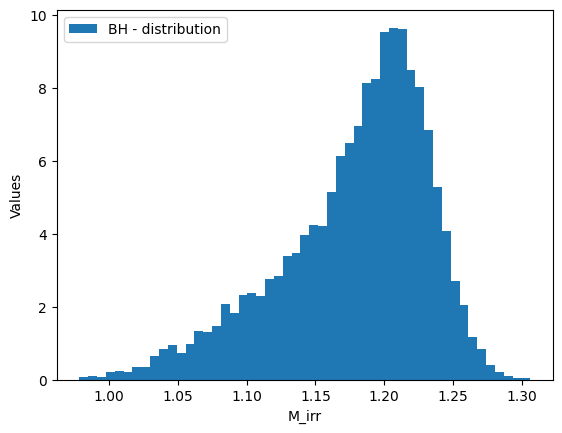

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from astroML import stats as astroMLstats

N = 10000

sigma = 0.02
mu = 1
M = np.random.normal(mu, sigma, N)
chi = np.random.uniform(0,1,N)

M_irr = M * np.sqrt( 1+ np.sqrt(1-chi**2)/2) #per definizione

sigmaG2 = astroMLstats.sigmaG(M_irr) # quantile al 75 - quantile al 25
binsize = 2.7 * sigmaG2 / (N**(1/3)) #formula di Freedman-Diaconis
binsG = np.append( np.arange(start=M_irr.min(), stop=M_irr.max(), step=binsize) , M_irr.max()) 

plt.hist(M_irr, 51, density=True, label = "BH - distribution")
plt.xlabel("M_irr")
plt.ylabel("Values")
plt.legend()
plt.show()

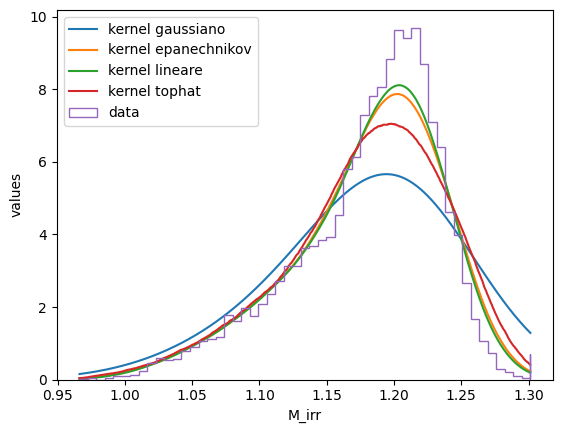

In [42]:
from sklearn.neighbors import KernelDensity

xgrid = np.linspace(M_irr.min(),M_irr.max(),1000)  

def kde (data, bandwidth, kernel):
    KDE = KernelDensity(bandwidth = bandwidth, kernel = kernel)
    KDE.fit(data[:, np.newaxis]) 
    log_pdf = KDE.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)


bandwidth = 0.05

pdf = kde (M_irr, bandwidth, kernel = "gaussian")       # funzione di densità della distribuzione normale
pdf2 = kde (M_irr, bandwidth, kernel = "epanechnikov")  # parabolico e ha un supporto finito, stima più localizzata rispetto al gaussiano
pdf3 = kde (M_irr, bandwidth, kernel = "linear")        # assegna pesi decrescenti linearmente alla distanza dal punto di riferimento. densità meno liscia rispetto al gaussiano
pdf4 = kde (M_irr, bandwidth, kernel = "tophat")        # kernel uniforme, che assegna lo stesso peso a tutti i punti entro una certa finestra e zero al di fuori. meno utilizzato perché può generare stime meno precise

plt.plot(xgrid,pdf, label = "kernel gaussiano")
plt.plot(xgrid,pdf2, label = "kernel epanechnikov")
plt.plot(xgrid,pdf3, label = "kernel lineare")
plt.plot(xgrid,pdf4, label = "kernel tophat")

plt.hist(M_irr, binsG, label = "data", density= True, histtype="step")
plt.xlabel("M_irr")
plt.ylabel("values")
plt.legend()
plt.show()


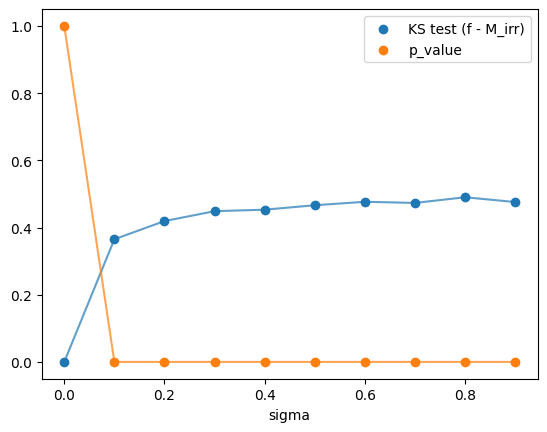

In [48]:
import scipy as sp

statistic = []
p_value = []
x = []

for i in range(10) :

    sigma =  i/10

    chi = np.random.uniform(0,1,N)
    M = np.random.normal(mu, sigma, N)

    M_irr = M * np.sqrt( 1+ np.sqrt(1-chi**2)/2)
    f = M_irr/M

    statistic_i , p_value_i = sp.stats.kstest(f , M_irr)

    statistic.append(statistic_i)
    p_value.append(p_value_i)

    x.append(sigma)


plt.scatter(x,statistic, label = "KS test (f - M_irr)")
plt.plot(x, statistic, linestyle="-", alpha=0.7)

plt.scatter(x, p_value, label = "p_value")
plt.plot(x, p_value, linestyle="-", alpha=0.7)

plt.xlabel("sigma")

plt.legend()
plt.show()


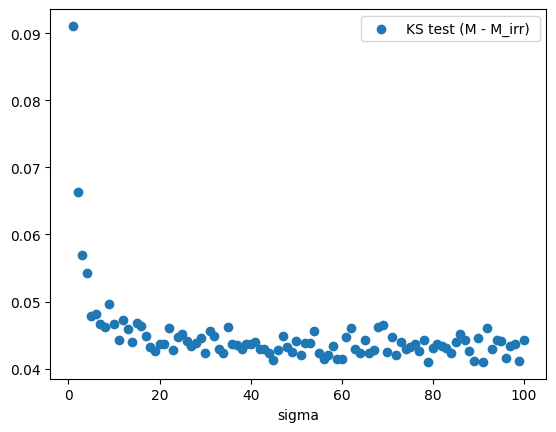

In [49]:
statistic = []
p_value = []
x = []

for i in range(100) :

    sigma =  i+1
    chi = np.random.uniform(0,1,N)

    M = np.random.normal(mu, sigma, N)

    M_irr = M * np.sqrt( 1+ np.sqrt(1-chi**2)/2)

    statistic_i , p_value_i = sp.stats.kstest(M , M_irr)

    statistic.append(statistic_i)
    p_value.append(p_value_i)

    x.append(sigma)


plt.scatter(x,statistic, label = "KS test (M - M_irr) ")
plt.xlabel("sigma")
plt.legend()
plt.show()
